# 4 - Evaluating the optimal policies #

This notebook evaluates the policies that were found on the pareto front by optimizing the model over our 'signal-to-noise' robustness function over the following KPIs:

- Expected Number of Deaths
- Expected Annual Damage
- Dike Investment Costs
- Variance of costs between locations
- Evacuation costs

And was constraint on RfR Costs, since RfR Costs are not the most favourable costs to make according to the involved actors.

From the full set of policies (106), we selected a set of 10 policies, which we will evaluate over 500 scenarios. With this evaluation we can visualize the performance of the policies. Lastly, we can provide a set of policies for Rijkswaterstaat. This set of policies consists of the most robust policies. The only thing Rijkswaterstaat needs to decide is what trade-offs they want to make. All of these choices will be elaborated in their specific parts.

In [1]:
# Import libraries, workbench and model
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import functools
import math
import pickle

from ema_workbench.analysis import parcoords
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario, Constraint)
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from dike_model.dike_model_function import DikeNetwork 
from dike_model.problem_formulation import get_model_for_problem_formulation


# The aggregation functions from "1 - Exploration"
def aggregate_kpi(data, kpi, aggregate):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    kpi_columns = []
    
    if kpi == "RfR Total Costs" or kpi == "Expected Evacuation Costs":
        kpi_columns.append(kpi + " 0")
        kpi_columns.append(kpi + " 1")
        kpi_columns.append(kpi + " 2")
        
        data[kpi] = data[kpi_columns].sum(axis=1)
    else:
        if aggregate is "total":
            for location in locations:
                kpi_columns.append(location + "_" + kpi + " 0")
                kpi_columns.append(location + "_" + kpi + " 1")
                kpi_columns.append(location + "_" + kpi + " 2")

            data[kpi] = data[kpi_columns].sum(axis=1)

        else:
            for location in locations:
                kpi_columns = []
                kpi_columns.append(location + "_" + kpi + " 0")
                kpi_columns.append(location + "_" + kpi + " 1")
                kpi_columns.append(location + "_" + kpi + " 2")

                data[location + "_" + kpi] = data[kpi_columns].sum(axis=1)
                
    return data

def variance_kpi(data, kpi):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    kpi_columns = []
    
    for location in locations:
        kpi_columns.append(location + "_" + kpi)
                    
    data["Variance " + kpi] = data[kpi_columns].std(axis=1)
    
    return data

def aggregate_rfr_policy(data):
    locations = [0, 1, 2, 3, 4]
    kpi = "RfR"
    kpi_columns = []
    
    for location in locations:
        kpi_columns = []
        kpi_columns.append(str(location) + "_" + kpi + " 0")
        kpi_columns.append(str(location) + "_" + kpi + " 1")
        kpi_columns.append(str(location) + "_" + kpi + " 2")

        data["A." + str(location+1) + "_" + kpi] = data[kpi_columns].sum(axis=1) / 3
        
    return data

In [2]:
# Open the MORO results
archive, convergence = pickle.load(open('results/MORORun.pkl', 'rb'))

# Give a quick indication how the results look like
archive

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Death Score,Annual Costs Score,Dike Costs Score,Variation Score,Evacuation Score
0,1,1,1,1,1,1,1,1,1,1,...,0,4,7,0,0,0.000001,1.032588e+10,199564.866738,7.058005e+11,3.658011e+01
1,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0.001849,1.583976e+15,98698.016657,3.156100e+14,1.000000e-06
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0.000032,1.739427e+15,92449.860573,3.097716e+14,5.730306e+06
3,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0.000022,1.970708e+15,93634.454180,2.862508e+14,9.946311e+06
4,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0.001716,2.305437e+15,88216.865065,2.846236e+14,1.000000e-06
5,1,1,1,1,1,1,1,1,1,1,...,3,0,7,0,0,0.000001,1.000000e-06,204706.212711,3.651945e-01,1.000000e-06


We convert the policies in a readable manner. By inspecting the policies, it came to our attention that the dike increase levers only occurred in "timestep 0", therefore we assumed that we were able to sum them.

For the RfR levers, we summed the values and divided this value by 3 (since there are 3 rounds). In this way, it is immediately clear how many RfR levers are implemented in total. 

In [3]:
policy_levers = archive
policy_levers = aggregate_kpi(policy_levers, "DikeIncrease", "location")
policy_levers = aggregate_rfr_policy(policy_levers)
policy_levers["EWS Days to Threat"] = policy_levers["EWS_DaysToThreat"]

policy_levers.iloc[:,-11:]

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,A.1_RfR,A.2_RfR,A.3_RfR,A.4_RfR,A.5_RfR,EWS Days to Threat
0,0,10,6,10,7,1.000000,1.000000,1.0,1.0,1.000000,3
1,0,4,1,0,1,1.000000,1.000000,1.0,1.0,0.666667,0
2,0,6,4,0,0,1.000000,1.000000,1.0,1.0,0.333333,2
3,0,5,7,0,0,0.666667,1.000000,1.0,1.0,0.000000,3
4,0,6,2,0,0,1.000000,0.666667,1.0,1.0,0.000000,0
5,0,10,6,12,7,1.000000,1.000000,1.0,1.0,0.333333,3


Afterwards, a quick inspection of the full set of policies has been executed. This inspection directly visualizes the trade-offs Rijkswaterstaat will face in determining the 'best-fit' policy. 

- Annual Damage vs Dike Investment costs
- Dike investment costs vs Variation of the costs between the locations
- And in lesser manner, the varation between the locations vs the evacuation costs

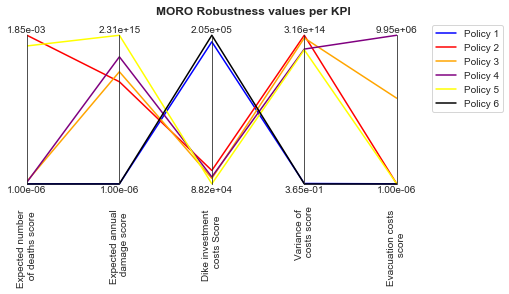

In [4]:
#Creating the parallel coordinate plot. For the legend, mlines has to be imported.
import matplotlib.lines as mlines

#Specifying the colors to use
colors=["blue", "red", "orange", "purple", "yellow", "black", "cyan", "brown", 'green', 'violet']

#Selecting the variables to be plotted and their corresponding names in the figure
outcomes = archive.loc[:, ['Death Score', 'Annual Costs Score', 'Dike Costs Score', 'Variation Score', 'Evacuation Score']]
outcomes.columns = ["Expected number \n of deaths score", 'Expected annual \n damage score', "Dike investment \n costs Score", "Variance of \n costs score", 'Evacuation costs \n score']

#Creating the axes for the correct limits and in the correct format
limits=parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits, fontsize=10, formatter={i: ".2e" for i in outcomes.columns})

#Drawing the lines. This is done with a for loop, because then each line can be given a color,
#and this is the only way we found to create a legend with such a plot
for policy in range(len(outcomes.values)):
    axes.plot(outcomes.iloc[policy,:], color=colors[policy])

#Creating the legend. The mlines function is used to create the lines in the legend. The color is given by indexing the 'colors' list.
#The labels are given by iterating over the indexes of the dataframe
plt.legend(handles=[mlines.Line2D([], [], color=i,
                          markersize=15, label="Policy %d"%(j+1)) for i,j in zip(colors, range(len(outcomes.values)))],loc=1, bbox_to_anchor=(1.7, 0., 0.5, 1))

plt.title("MORO Robustness values per KPI", fontdict={'horizontalalignment':"right", 'fontweight':'bold'})
plt.savefig("images/Robustness tradeoffs policies MORO run.png", bbox_inches='tight')
plt.show()

### Re-evaluating  the found policies and visualization ###

For the optimization algorithm we only used 40 scenarios. What will happen to the 'best' policies when we test them over 500 scenarios? What policies will be the most robust and will perform best on our KPIs? Following from this evaluation, we will select 5 policies for Rijkswaterstaat that will perform best on the KPIs and are the most robust to uncertainties in the uncertainty space. The only thing left for Rijkswaterstaat is making a decision based on the trade-offs that will be presented below.

In [5]:
# Convert the policy dataframe to policy-objects
policy_list = []
for row in range(archive.shape[0]):
    policy_list.append(Policy(name=(row+1), **archive.iloc[row, :-5].to_dict()))

# Import dike model
dike_model, planning_steps = get_model_for_problem_formulation(5)

#Running the experiments (commented out)
# with MultiprocessingEvaluator(dike_model, n_processes = 10) as evaluator:
#     results = evaluator.perform_experiments(scenarios=1000, policies=policy_list)
# utilities.save_results(results, 'results/1000ScenariosBestPoliciesPF5.csv')


experiments, outcomes = utilities.load_results('results/1000ScenariosBestPoliciesPF5.csv')

# Turn into a dataframe
df_outcomes = pd.DataFrame(outcomes)
results = pd.concat([experiments,df_outcomes],axis=1,sort=False)

# Let the policy counter start from 1 in stead of 0
rename = lambda x: "policy " + str(int(x.split()[1])+1)
results["policy"] = results["policy"].apply(rename)

results.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\marce\Desktop\MBDM Project\results\1000ScenariosBestPoliciesPF5.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,100.0,113.102197,1.5,0.120577,138.717452,1.5,0.867670,326.800934,10.0,0.132455,...,0,0.0,0.0,1.186070e+07,0.0,0.0,0,0.0,710400000.0,0.0
1,113.0,153.533768,10.0,0.949436,335.775967,10.0,0.580748,244.297243,1.0,0.520354,...,0,0.0,0.0,1.186070e+07,0.0,0.0,0,0.0,710400000.0,0.0
2,38.0,233.895356,10.0,0.859382,270.038291,1.0,0.829554,165.204348,10.0,0.539679,...,0,0.0,0.0,1.186070e+07,0.0,0.0,0,0.0,710400000.0,0.0
3,12.0,59.373084,10.0,0.812381,292.082111,1.0,0.821081,103.192340,1.5,0.921696,...,0,0.0,0.0,1.186070e+07,0.0,0.0,0,0.0,710400000.0,0.0
4,103.0,85.569989,1.5,0.462374,272.222847,10.0,0.721255,145.061412,10.0,0.205942,...,0,0.0,0.0,1.186070e+07,0.0,0.0,0,0.0,710400000.0,0.0


### Visualization ###

In order to give you a clear overview which policies we will provide to Rijkswaterstaat, all the steps in picking these policies have been visualized and elaborated on.

In [6]:
# Append the KPIs we would like to analyse. The RfR total costs and expected evacuation costs are included for later on in the analysis, but are not used for the base case analysis, as they are still 0.
results = aggregate_kpi(results, "Expected Number of Deaths", "location")
results = aggregate_kpi(results, "Expected Number of Deaths", "total")
results = aggregate_kpi(results, "Expected Annual Damage", "location")
results = aggregate_kpi(results, "Expected Annual Damage", "total")
results = aggregate_kpi(results, "Dike Investment Costs", "location")
results = aggregate_kpi(results, "Dike Investment Costs", "total")
results = aggregate_kpi(results, "RfR Total Costs", "total")
results = aggregate_kpi(results, "Expected Evacuation Costs", "total")
results["A.1_Sum Damage Costs"] = results["A.1_Expected Annual Damage"] + results["A.1_Dike Investment Costs"]
results["A.2_Sum Damage Costs"] = results["A.2_Expected Annual Damage"] + results["A.2_Dike Investment Costs"]
results["A.3_Sum Damage Costs"] = results["A.3_Expected Annual Damage"] + results["A.3_Dike Investment Costs"]
results["A.4_Sum Damage Costs"] = results["A.4_Expected Annual Damage"] + results["A.4_Dike Investment Costs"]
results["A.5_Sum Damage Costs"] = results["A.5_Expected Annual Damage"] + results["A.5_Dike Investment Costs"]

results = variance_kpi(results, "Sum Damage Costs")

# Select the KPIs we want to see and add the "Total Policy Cost" KPI, "Policy" and "Scenario" which are indicators
df_ooi = results.iloc[:,-27:]
df_ooi["Total Policy Costs"] = df_ooi["RfR Total Costs"]+df_ooi["Expected Evacuation Costs"]+results["Dike Investment Costs"]
df_ooi["Policy"] = results["policy"]
df_ooi["Scenario"] = experiments["scenario"]

df_ooi.head()

,Expected Evacuation Costs 2,A.1_Expected Number of Deaths,A.2_Expected Number of Deaths,A.3_Expected Number of Deaths,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,Expected Number of Deaths,A.1_Expected Annual Damage,A.2_Expected Annual Damage,A.3_Expected Annual Damage,...,Expected Evacuation Costs,A.1_Sum Damage Costs,A.2_Sum Damage Costs,A.3_Sum Damage Costs,A.4_Sum Damage Costs,A.5_Sum Damage Costs,Variance Sum Damage Costs,Total Policy Costs,Policy,Scenario
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.952540e+07,3.139880e+07,2.444716e+07,4.419351e+07,3.700234e+07,2.330765e+09,policy 1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.952540e+07,3.139880e+07,2.444716e+07,4.419351e+07,3.700234e+07,2.330765e+09,policy 1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.952540e+07,3.139880e+07,2.444716e+07,4.419351e+07,3.700234e+07,2.330765e+09,policy 1,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.952540e+07,3.139880e+07,2.444716e+07,4.419351e+07,3.700234e+07,2.330765e+09,policy 1,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.952540e+07,3.139880e+07,2.444716e+07,4.419351e+07,3.700234e+07,2.330765e+09,policy 1,4


First of all, we test how the aggregate KPIs perform over the scenario's. As we can see, the KPIs that should be minimized (Deaths, Annual damage and variance between locations) are almost minimized in every scenario. There are some outliers but overall the "Expected Number of Deaths" is valued 0. The "Expected Annual Damage also has some outliers, but most of the cases the value is as close to a minimum value that is shared by all scenarios. These numbers are very promising, since this is what Rijkswaterstaat aims for: the least amount of deaths and the least amount of damage. However, it has to be said that a chance of having relatively high deaths and costs within a policy is unwanted, further analysis will bring to light which policies are prone to these outliers. 

Lastly, analyzing the "Total Policy Costs", indicates that the policies significantly differ in costs. This fact implies the aforementioned trade-off decision Rijkswaterstaat has to make. 

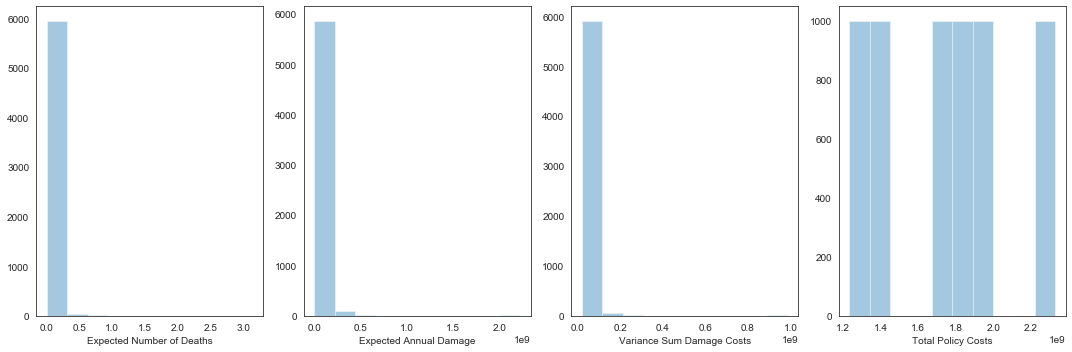

In [7]:
f, axes = plt.subplots(1, 4, figsize=(15,5))

sns.distplot(df_ooi["Expected Number of Deaths"], bins=10, kde=False, ax=axes[0])
sns.distplot(df_ooi["Expected Annual Damage"], kde=False, bins=10, ax=axes[1])
sns.distplot(df_ooi["Variance Sum Damage Costs"], bins=10, kde=False, ax=axes[2])
sns.distplot(df_ooi["Total Policy Costs"], bins=10, kde=False, ax=axes[3])

plt.tight_layout()
plt.show()

To indicate the outliers within the run, we use a pairplot. This pairplot clearly indicates which policies have some outliers. However, this does not indicate that these policies could be less robust. This only gives a quick insight in the possible outliers and is used to check the behavior of the policies.

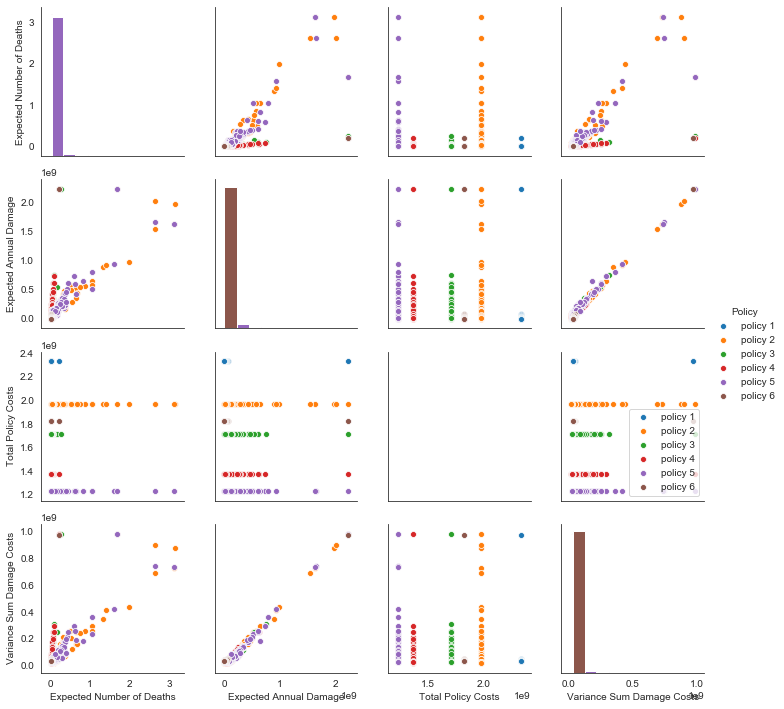

In [8]:
sns.pairplot(df_ooi, hue='Policy', vars=["Expected Number of Deaths", "Expected Annual Damage", "Total Policy Costs", "Variance Sum Damage Costs"], diag_kind="hist")
plt.legend()
plt.show()

In order to check the policies for robustness on our KPIs, we visualize them with boxplots. A larger boxplot means that the values of the KPI per policy per scenario differ more, this (in)directly means that the policy is less robust (since it gives a more distributed view of the performance of the policy).

To elaborate on this further, let's assume we have 5 scenarios and we compare the KPI "Expected Number of Deaths". Policy 1 has 5 deaths in every scenario, and policy 2 has "2, 4, 6, 8 and 1" deaths accordingly. Policy 1 may not be the best performer, however it is the most robust one (since you know for sure if you implement that policy, 5 deaths occur). On the contrary, policy 2 does perform better if we calculate the mean, however is this said  to be robust? Will Rijkswaterstaat pick a policy in which it is possible that a policy can result in 8 deaths? Therefore, comparing the boxplots is an essential step in order to choose the best policies.

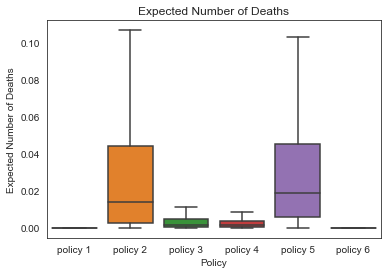

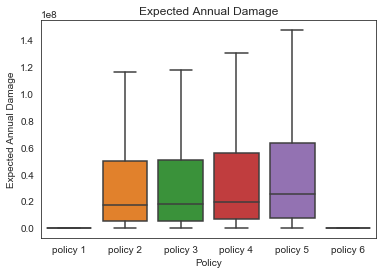

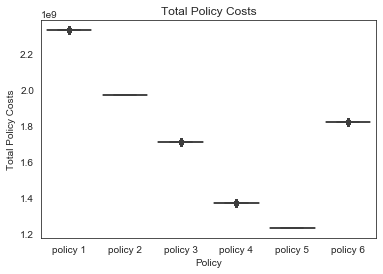

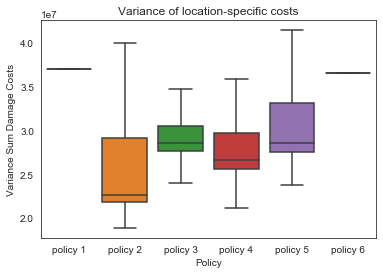

In [9]:
plt.figure(figsize=(6,4))
plt.title("Expected Number of Deaths")
f = sns.boxplot(x=df_ooi["Policy"], y=df_ooi["Expected Number of Deaths"], showfliers =False)
plt.savefig("images/Optimal Policies - Boxplot Deaths.png")
plt.show()

plt.figure(figsize=(6,4))
plt.title("Expected Annual Damage")
f = sns.boxplot(x=df_ooi["Policy"], y=df_ooi["Expected Annual Damage"], showfliers =False)
plt.savefig("images/Optimal Policies - Boxplot Damage.png")
plt.show()

plt.figure(figsize=(6,4))
plt.title("Total Policy Costs")
f = sns.boxplot(x=df_ooi["Policy"], y=df_ooi["Total Policy Costs"], showfliers =True)
plt.savefig("images/Optimal Policies - Boxplot Costs.png")
plt.show()

plt.figure(figsize=(6,4))
plt.title("Variance of location-specific costs")
f = sns.boxplot(x=df_ooi["Policy"], y=df_ooi["Variance Sum Damage Costs"], showfliers =False)
plt.savefig("images/Optimal Policies - Boxplot Variance.png")
plt.show()

As we can see from the boxplot, policies 2 and 5 seems less robust, because of their bigger difference between the minimum and the maximum value and the quartile distance on every KPI. Additionally, policy 4 seems to also perform less robust compared to the other policies. By comparing the policies by "Total Policy Costs", the "less robust" performing policies are the most "cheapest" options. Therefore, we do not immediately exclude these policies from our policy-set, because the trade-off between costs vs deaths and annual damage is an important one to make.

Our goal of this optimization is to find the most robust policies, that perform best over the decided KPIs. Therefore, based on our boxplots and scenario analysis, we can identify the policies that seem less robust when we run them over multiple scenarios. As we explained before, for Rijkswaterstaat it is more convenient to pick a solution where they know the estimated outcome is more or less certain, than to pick a solution in which it can occur that the KPIs might get a value that is not desired. The next step will further elaborate the robustness of the policies.

## Trade-off for Rijkswaterstaat ##

It is now time to re-evaluate the robustness functions over the results of the scenario analysis. By calculating the robustness values, we can indicate which of these policies perform best on the KPIs and which trade-offs are present within our set. This does increase our validity of the robustness identification, since the MORO-algorithm was runned with 30 scenarios and now we are running 1000 scenarios. 

The new retrieved robustness values will be visualized. With this visualization and the visualization of the absolute values, Rijkswaterstaat can make a well informed choice which policy is effective in mitigating the flood risks and accepted by all relevant actors.

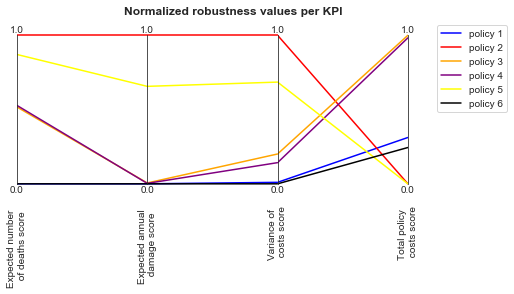

In [10]:
# Imported from "3 - Moro"
def signal_to_noise(data):
        
    mean = np.mean(data)
    std = np.std(data)
    return (mean + 0.001) * (std + 0.001)

# Specify the columns we want to plot, we take the total policy costs now to calculate the robustness value over
# since that is the KPI we would like to communicate
df_robust = df_ooi[["Expected Number of Deaths", "Expected Annual Damage", "Variance Sum Damage Costs", "Total Policy Costs", "Policy"]]

# Create the Robustness dataframe, this function is introduced within week 5-6. 
overall_robustness = {}

# For every policy, get the values of the KPI, and apply the signal_to_noise function to it
for policy in np.unique(df_robust['Policy']):
    policy_robustness = {}

    logical = df_robust['Policy'] == policy
    
    for outcome, values in df_robust.iloc[:,:-1].items():
        values = values[logical]
        policy_robustness[outcome] = signal_to_noise(values.values)
    
    overall_robustness[policy] = policy_robustness

overall_robustness = pd.DataFrame.from_dict(overall_robustness).T

# Normalize the values, so it is easier to interpret for Rijkswaterstaat 
# (since robustness values themselves will not have any value for them)
normalized = (overall_robustness - overall_robustness.min()) / (overall_robustness.max() - overall_robustness.min())
normalized = normalized.reset_index()

# The order of columns we want
normalized = normalized[["index","Expected Annual Damage","Expected Number of Deaths", "Variance Sum Damage Costs", "Total Policy Costs"]]

#Creating parallel coordinate plot in a similar fashion as before: first getting the columns, then creating the axes, then using
#a for loop for iteratively forming all the lines (so that they can be given a unique color, which can be used for the legend)
#and then creating a legend.
normalized.columns = ["Policy", "Expected number \n of deaths score", 'Expected annual \n damage score', "Variance of \n costs score", 'Total policy \n costs score']
limits=parcoords.get_limits(normalized.iloc[:,1:])
axes = parcoords.ParallelAxes(limits, fontsize=10, formatter={i: ".1f" for i in normalized.iloc[:,1:].columns})
for policy in range(len(normalized.values)):
    axes.plot(normalized.iloc[policy,:], color=colors[policy])
    
#In this case, the legend labels are given by the 'policy' column in the dataframe, so that the correct policy numbers are shown
plt.legend(handles=[mlines.Line2D([], [], color=i, markersize=15, label=normalized.iloc[j,0]) 
                    for i,j in zip(colors, range(len(normalized.values)))],loc=1, bbox_to_anchor=(1.7, 0., 0.1, 1))

plt.title("Normalized robustness values per KPI", fontdict={'horizontalalignment':"right", 'fontweight':'bold'})
plt.savefig("images/Tradeoffs Robustness 6 policies.png", bbox_inches='tight')
plt.show()

To elaborate on this even more, we create a trade-off with actual values, this has been done by taking the mean of all the scenarios per policy.

As we can see, the trade-off is mainly about policy costs vs deaths, damage costs and the variance of costs between the locations. If we want to minimize the deaths, damages and variance, the policy costs will be high. However, we are still talking about good outcomes! The difference in deaths as seen in the table below is about very small differences. However, it can be understood that minimizing the KPIs comes at a cost.

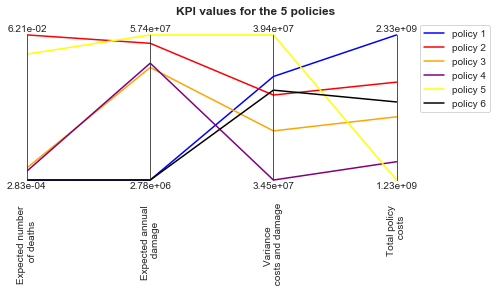

In [11]:
# Creating the final parallel coordinate plot
# Get the kpi's we want from the earlier made dataframe.
# We group the scenario's and retrieve the mean-value. 
df_grouped = df_ooi[["Expected Number of Deaths", "Expected Annual Damage", "Variance Sum Damage Costs", "Total Policy Costs", "Policy"]]
df_grouped = df_grouped.groupby(by="Policy").mean().reset_index()
df_table = df_grouped

#Creating parallel coordinate plot in a similar fashion as before: first getting the columns, then creating the axes, then using
#a for loop for iteratively forming all the lines (so that they can be given a unique color, which can be used for the legend)
#and then creating a legend.
df_table.columns = ["Policy", "Expected number \n of deaths", 'Expected annual \n damage', "Variance \n costs and damage", 'Total policy \n costs']

# Get the limits and axes, eventually plot
limits=parcoords.get_limits(df_table.iloc[:,1:])
axes = parcoords.ParallelAxes(limits, fontsize=10, formatter={i: ".2e" for i in df_table.iloc[:,1:].columns})
for policy in range(len(df_table.values)):
    axes.plot(df_table.iloc[policy,:], color=colors[policy])
    
plt.legend(handles=[mlines.Line2D([], [], color=i, markersize=15, label=df_table.iloc[j,0]) 
                    for i,j in zip(colors, range(len(df_table.values)))],loc=1, bbox_to_anchor=(1.7, 0., 0.1, 1))

plt.title("KPI values for the 5 policies", fontdict={'horizontalalignment':"right", 'fontweight':'bold'})
plt.savefig("images/Tradeoffs 5 policies.png", bbox_inches='tight')
plt.show()

In [12]:
df_table

,Policy,Expected number of deaths,Expected annual damage,Variance costs and damage,Total policy costs
0,policy 1,0.000283,2.796481e+06,3.798139e+07,2.330765e+09
1,policy 2,0.062138,5.423697e+07,3.735116e+07,1.973795e+09
2,policy 3,0.005486,4.512410e+07,3.613099e+07,1.711451e+09
3,policy 4,0.004129,4.675612e+07,3.445879e+07,1.371935e+09
4,policy 5,0.053968,5.739326e+07,3.939701e+07,1.233313e+09
5,policy 6,0.000289,2.781330e+06,3.751744e+07,1.823700e+09
